# Multiclass Classification

* Find this notebook at `EpyNN/nnlive/captcha_mnist/train.ipynb`.
* Regular python code at `EpyNN/nnlive/captcha_mnist/train.py`.

In this notebook we will review:

* Handling numerical data image to proceed with Neural Network regression.
* Training of Feed-Forward (FF) and Convolutional Neural Network (CNN) for multiclass classification task.
* MNIST database as a benchmark for neural networks.

Please see the following if you get lost:

* [Fully Connected (Dense)](../../Dense.html)
* [Convolution (CNN)](../../Convolution.html)
* [Pooling (CNN)](../../Pooling.html)

 Please follow this [external link](http://yann.lecun.com/exdb/mnist/) for detailed contextual information about the MNIST database.

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, the MNIST database contains 70 000 images (60K + 10k).

Each image contains a single handwritten digit. In total, 500 different human writters contributed to the whole.

The MNIST database is curated in that images were size normalized and centered.

In [1]:
# EpyNN/nnlive/captcha_mnist/train.ipynb
# Standard library imports
import random

# Related third party imports
import matplotlib.pyplot as plt
import numpy as np

# Local application/library specific imports
import nnlibs.initialize
from nnlibs.commons.maths import relu, softmax
from nnlibs.commons.library import (
    configure_directory,
    read_model,
)
from nnlibs.network.models import EpyNN
from nnlibs.embedding.models import Embedding
from nnlibs.convolution.models import Convolution
from nnlibs.pooling.models import Pooling
from nnlibs.flatten.models import Flatten
from nnlibs.dropout.models import Dropout
from nnlibs.dense.models import Dense
from prepare_dataset import (
    prepare_dataset,
    download_mnist,
)
from settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)
np.random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')

configure_directory()


############################ DATASET ##########################
download_mnist()

X_features, Y_label = prepare_dataset(N_SAMPLES=750)

Let's control what we retrieved.

In [2]:
print(len(X_features))
print(X_features[0].shape)
print(set(X_features[0].flatten().tolist()))    # Get all unique tones in image

750
(28, 28, 1)
{0.0, 3.0, 6.0, 11.0, 12.0, 13.0, 15.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 27.0, 28.0, 32.0, 39.0, 40.0, 42.0, 43.0, 44.0, 45.0, 46.0, 48.0, 55.0, 67.0, 82.0, 86.0, 87.0, 90.0, 91.0, 94.0, 97.0, 100.0, 101.0, 104.0, 107.0, 110.0, 112.0, 115.0, 116.0, 125.0, 127.0, 129.0, 143.0, 147.0, 150.0, 151.0, 155.0, 158.0, 162.0, 163.0, 166.0, 167.0, 169.0, 170.0, 172.0, 181.0, 183.0, 184.0, 186.0, 189.0, 202.0, 205.0, 206.0, 210.0, 211.0, 214.0, 215.0, 219.0, 220.0, 221.0, 223.0, 225.0, 227.0, 228.0, 230.0, 233.0, 234.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 247.0, 250.0, 252.0, 253.0, 255.0}


We retrieved sample features describing ``7500`` samples.

For each sample, we retrieved  features as a three-dimensional array of shape ``(widht, height, depth)``. Each image has dimension 28x28 and so contains 784 pixels.

In the context, remember that the ``depth`` dimension represents the number of channels which encode the image. While the depth of any RGB image would be equal to 3, the depth of a grayscale image is equal to one. We namely have a regular grayscale image in that shades of gray range from 0 to 255. 

Let's recall how this looks like.

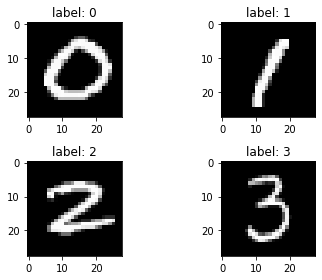

In [3]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)

ax0.imshow(X_features[Y_label.index(0)], cmap='gray')
ax0.set_title('label: 0')

ax1.imshow(X_features[Y_label.index(1)], cmap='gray')
ax1.set_title('label: 1')

ax2.imshow(X_features[Y_label.index(2)], cmap='gray')
ax2.set_title('label: 2')

ax3.imshow(X_features[Y_label.index(3)], cmap='gray')
ax3.set_title('label: 3')

plt.tight_layout()
plt.show()

According to [comments from the authors](http://yann.lecun.com/exdb/mnist/) of the MNIST database: *"The original black and white (bilevel) images from NIST were size normalized \[...\]. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm"*.

## Feed-Forward (FF)

As explained in other exemples of network training, we like to begin by a Feed-Forward network each time we start to investigate a new problem. This because:

* Feed-Forward (Dense-based) network are computationally faster to train than other architectures.
* Such network may be less sensitive to training hyperparameters and thus they are easier to train.
* There is no reasonable day/night results depending on the architecture: one Feed-Forward - even if inappropriate - architecture may result in metrics that will not be made twice better by using an appropriate architecture. This mostly depends on hyperparameters and data processing.

About this last item, one may look at the above-linked page which reports on classifier error rate with respect to method or architecture.

As a condensate:

* Single-layer FF (Perceptron) - 12.0% error.
* Single-layer FF (Perceptron) - 7.6% error with deskewing.
* Two-layers FF with 800 hidden nodes - 1.6% error.
* Committee of 35 Convolutional Neural Networks (CNN) - 0.23% error (best of all reported).

First, we can see that from the very basic perceptron to the most evolved CNN there is an improvement from 88% to 99.77% accuracy. This is a huge gap, but both architecture succeed at recognizing patterns and drawing a decent model. 

Note the gap is significantly reduced by simply applying *deskewing* to the image data, which highlights the critical importance of data pre-processing in the ability of the network to result in an accurate model.

Also note that perceptron are only able of linear regression while multi-layers Feed-Forward or CNN and other architectures can achieve non-linear regressions.

When considering the two-layers FF with 800 hidden nodes versus the state-of-the-art CNN, the accuracy goes from 98.4% to 99.77%. Overall, this illustrates that classical Feed-Forward networks may be a good alternative to more appropriate architecture when balancing between accuracy, hardness of training and need for more computational time.

### Embedding

We start from sample features containing values ranging from 0 to 255.

The most important things is to **normalize** sample features withing \[0, 1\].

The second thing is to set a batch size which, in this case, will makes the regression converging faster.

The last - but not least - thing is to one-hot encode the set of sample label. While one may not do this with binary classification problems and thus use a single node in the output dense layer - from which 0 or 1 decisions can be extracted -, the same can not reasonably be done with multiclass classification. Because we have ten distinct labels in the game, the reasonable choice is to use 10 output nodes and to one-hot encode the set of sample label.

In [4]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

About data normalization:

* It diminishes the complexity of the problem.
* It accelerates training and makes it easier.
* If no normalization is done in this example, the loss function and gradients will both readily explode and generate floatting points errors.

About this last point, remember that exponentials are used in the context of neural networks. If you begin feeding exponential functions with large numbers such as 255, you can be sure you will get floatting points errors pretty quickly: the computer typically deals with 64-bits float number, which has maximal value of ``1.8 * 10 ** 308``. 

Note that in previously used 32-bits processors architecture, this maximal value was down to ``3.4 * 10 ** 38``. Compare with ``exp(255)`` which outputs ``5.56 * 10 ** 110`` and conclude that un-normalized data in the context of this notebook would have overflowed straight away on a - not that ancient - 32-bits system. Actually, if you attempt to run this notebook on a [Raspberry Pi](https://www.raspberrypi.org/) - why not? - you would overflow without normalization because the device relies on 32-bits CPUs.  

### Flatten-(Dense)n with Dropout

We already explained why we need to use a *flatten* layer when willing to forward arrays of more than 2 dimensions to the *dense* layer: image data have three dimensions, and the array of sample features - the array of sample image - has four dimensions. Therefore we need to flatten this array to give it a bi-dimensional shape.

In [5]:
name = 'Flatten_Dropout02_Dense-64-relu_Dropout05_Dense-10-softmax'

se_hPars['learning_rate'] = 0.001
se_hPars['softmax_temperature'] = 5

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.5)

dense = Dense(10, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We have set up a custom learning rate, along with the 10 nodes in the output layers because we have labels one-hot encoded over 10 digit and again because we have ten distinct labels.

Dropout layers were set to reduce overfitting and the *softmax temperature* was set higher than one to smooth the output probability distribution which practically results in more numerically stable training.

In [6]:
model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

We have set the loss function to use *Categorical Cross Entropy* instead of *Binary Cross Entropy*. This because we have ten distinct labels instead of two.

In [7]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 14/14 - Accuracy: 0.969 Cost: 0.11338 - TIME: 75.13s RATE: 7.45e+04e/s TTC: 0s

+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |       | accuracy |       |  CCE  |                              Experiment                               |
|       |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                       |
+-------+----------+----------+-------+----------+-------+-------+-----------------------------------------------------------------------+
|   0   | 1.00e-03 | 1.00e-03 | 0.246 |  0.216   | 2.238 | 2.242 | 1630636243_Flatten_Dropout02_Dense-64-relu_Dropout05_Dense-10-softmax |
|  10   | 1.00e-03 | 1.00e-03 | 0.690 |  0.652   | 1.164 | 1.264 | 1630636243_Flatten_Dropout02_Dense-64-relu_Dropout05_Dense-10-softmax |
|  20   | 1.00e-03 | 1.00e-03 | 0.800 |  0.728   | 0.737 | 0.918 | 16

Again the Feed-Forward network has been quite performant to reproduce the training data, less about the testing ones. Overfitting is a general problem in the field.

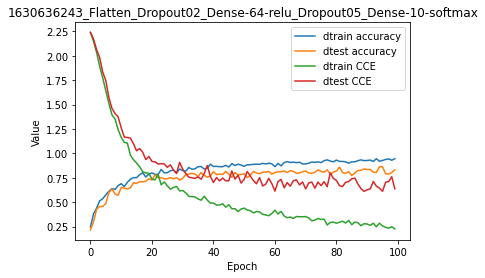

In [8]:
model.plot(path=False)

We will not try to optimize this Feed-Forward network to go ahead with Convolutional networks.

## Convolutional Neural Network (CNN)

As detailed in [another notebook](nnlive/dummy_image/train.html#Convolutional-Neural-Network-(CNN)), CNNs are preferred when it comes to consider *a priori* spatial relationships between data points.

### Embedding

Using same embedding configuration than above.

In [9]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_scale=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

Note that we use only *500 + 250* sample images herein. Benchmarks using the MNIST Database generally employ the whole 60 000 images for the training set itself, but it is likely to overload the RAM or not run at all on many system configurations. 

### Conv-MaxPool-Flatten-Dense

Using a single *Convolution-Pooling* block with ``16`` filters and *4x4* filter window for the *Convolution* layer.

In [10]:
name = 'Convolution-16-2_Pooling-3-Max_Flatten_Dense-10-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['softmax_temperature'] = 5

layers = [
    embedding,
    Convolution(unit_filters=16, filter_size=(2, 2), activate=relu),
    Pooling(pool_size=(2, 2)),
    Flatten(),
    Dense(10, softmax)
]

model = EpyNN(layers=layers, name=name)

Initialize the model with *Categorical Cross Entropy* loss.

In [11]:
model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 20 epochs.

In [12]:
model.train(epochs=10, init_logs=False)

Epoch 9 - Batch 14/14 - Accuracy: 0.938 Cost: 0.31801 - TIME: 13.35s RATE: 7.33e+02e/s TTC: 0s

+-------+-------------+----------+-------+----------+-------+-------+--------------------------------------------------------------------+
| epoch |    lrate    |  lrate   |       | accuracy |       |  CCE  |                             Experiment                             |
|       | Convolution |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                    |
+-------+-------------+----------+-------+----------+-------+-------+--------------------------------------------------------------------+
|   0   |  5.00e-03   | 5.00e-03 | 0.318 |  0.272   | 1.922 | 1.993 | 1630636321_Convolution-16-2_Pooling-3-Max_Flatten_Dense-10-softmax |
|   1   |  5.00e-03   | 5.00e-03 | 0.730 |  0.688   | 1.057 | 1.130 | 1630636321_Convolution-16-2_Pooling-3-Max_Flatten_Dense-10-softmax |
|   2   |  5.00e-03   | 5.00e-03 | 0.768 |  0.764   | 0.764 | 0.802 | 

The overfitting using this CNN architecture is reduced compared with the pure Feed-Forward design. However, accuracy remains slightly lower for both training and testing data.

Note the ``learning_rate`` may be a bit too high here: there are jump up and down for both accuracy and loss, particularly visible on the testing set.

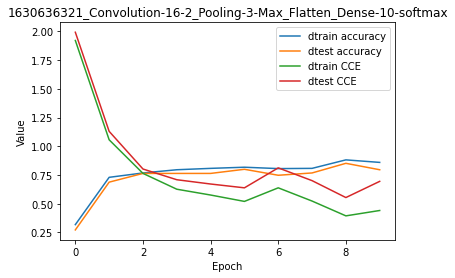

In [13]:
model.plot(path=False)

Looking at the plot, the model seems to have converged.

We will try to optimize it further.

### Conv-MaxPool-Flatten-(Dense)n

Below we added one ``Dense(64, relu)`` hidden layer. This is the same design than used for the Feed-Forward network excepted, of course, for the *Convolution-Pooling* block. The thing to pay attention to here is the absence of *Dropout* layer compared to the Feed-Forward network.

Epoch 9 - Batch 14/14 - Accuracy: 0.969 Cost: 0.18602 - TIME: 12.59s RATE: 5.40e+02e/s TTC: 0s

+-------+-------------+----------+----------+-------+----------+-------+-------+----------------------------------------------------------------------------------+
| epoch |    lrate    |  lrate   |  lrate   |       | accuracy |       |  CCE  |                                    Experiment                                    |
|       | Convolution |  Dense   |  Dense   |  (0)  |   (1)    |  (0)  |  (1)  |                                                                                  |
+-------+-------------+----------+----------+-------+----------+-------+-------+----------------------------------------------------------------------------------+
|   0   |  5.00e-03   | 5.00e-03 | 5.00e-03 | 0.330 |  0.280   | 1.909 | 1.985 | 1630636334_Convolution-16-2_Pooling-3-Max_Flatten_Dense-64-relu_Dense-10-softmax |
|   1   |  5.00e-03   | 5.00e-03 | 5.00e-03 | 0.600 |  0.612   | 1.290 | 1.313 | 163

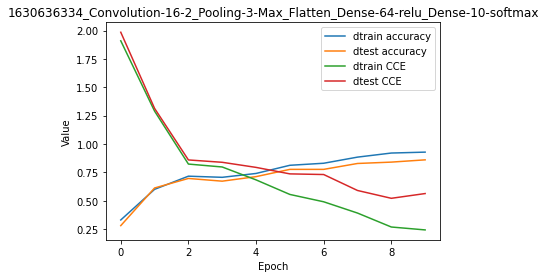

In [14]:
name = 'Convolution-16-2_Pooling-3-Max_Flatten_Dense-64-relu_Dense-10-softmax'

se_hPars['learning_rate'] = 0.005
se_hPars['softmax_temperature'] = 5

layers = [
    embedding,
    Convolution(unit_filters=16, filter_size=(2, 2), activate=relu),
    Pooling(pool_size=(2, 2)),
    Flatten(),
    Dense(64, relu),
    Dense(10, softmax)
]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='CCE', seed=1, se_hPars=se_hPars.copy(), end='\r')

model.train(epochs=10, init_logs=False)

model.plot(path=False)

This result is better than the one obtained with the Feed-Forward network. Although we did not use *Dropout* regularization, there is less overfitting and higher accuracy on the testing set.

## Write, Read & Predict

In [15]:
### Write/read model

model.write()

model = read_model()


### Predict

X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_scale=True)

for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

Make: /media/synthase/beta/EpyNN/nnlive/captcha_mnist/models/1630636334_Convolution-16-2_Pooling-3-Max_Flatten_Dense-64-relu_Dense-10-softmax.pickle
0 4 [2.41170822e-04 7.46186956e-07 7.07716754e-04 2.73031490e-04
 9.95601665e-01 5.49060125e-04 1.48488031e-04 2.35899261e-05
 1.26953655e-04 2.32757797e-03]
1 1 [2.00499462e-06 8.30372213e-01 1.48334304e-01 1.70373887e-03
 7.53930166e-05 1.31297812e-02 2.38000080e-03 2.82469591e-04
 3.58257878e-03 1.37515622e-04]
2 3 [7.88716265e-03 8.76252128e-10 6.05218506e-04 9.55619261e-01
 1.08480112e-06 3.34724200e-02 5.15425984e-08 6.75031814e-07
 2.41186270e-03 2.26273080e-06]
3 5 [5.96424285e-04 8.10955260e-06 6.08970317e-03 3.79520785e-01
 3.41094914e-06 6.00860892e-01 2.55325656e-06 3.92733160e-05
 1.27970449e-02 8.18031933e-05]
4 1 [2.78366412e-06 9.72345469e-01 9.53111701e-03 8.53663056e-06
 2.27664677e-04 3.71129574e-04 3.29556453e-04 3.31676830e-04
 1.68362951e-02 1.57714990e-05]
5 4 [5.81135846e-04 1.16403301e-05 2.46834453e-03 3.15430408e